## Downloading and plotting panstarrs images

In [1]:
from astropy.coordinates import SkyCoord
from panstarrs3 import panstarrs as p3

In [2]:
tcoord = SkyCoord.from_name('Kepler 13')
ps = p3.Panstarrs(ra=tcoord.ra.deg, dec=tcoord.dec.deg,
                  color=True)

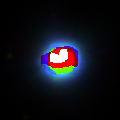

In [5]:
ps.format = "png"
cimg = ps.get_color_img()
cimg

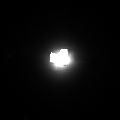

In [7]:
gimg = ps.get_gray_img(filter='g')
gimg 

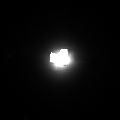

In [8]:
gimg = ps.get_gray_img(filter='z')
gimg 

In [9]:
img, hdr = ps.get_fits(verbose=True)

Filename: /home/jp/.astropy/cache/download/py3/f2c9c857e5b3bec8c69ba8fa2fa54cd8
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     246   (120, 120)   float32   
None


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


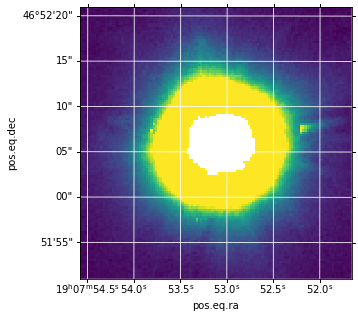

In [10]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
import matplotlib.pyplot as pl
from astropy import units as u

# tcoord = SkyCoord.from_name('Kepler 13')
ps = p3.Panstarrs(ra=tcoord.ra.deg, dec=tcoord.dec.deg,
               filters="g", format="fits", color=False)
interval = ZScaleInterval(contrast=0.5)
img, hdr = ps.get_fits(verbose=False)
zmin, zmax = interval.get_limits(img)

fig = pl.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection=WCS(hdr))
ax.imshow(img, vmin=zmin, vmax=zmax, cmap='viridis', origin='lower')
ax.grid(color='white', ls='solid')

## Other archival images can be accessed using astroplan

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x7f7a788b2190>,
 <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f7a788b2790>)

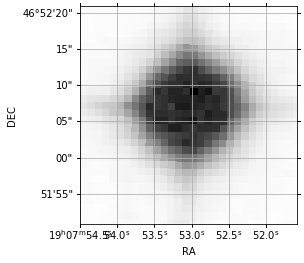

In [11]:
from astroplan.plots import plot_finder_image

plot_finder_image(tcoord, survey='DSS2 Red', fov_radius=30*u.arcsec)

## comparison

In [12]:
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
import numpy as np
from chronos import get_dss_data, plot_dss_image
import matplotlib.pyplot as pl
from matplotlib.patches import Circle
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS

def plot_archival_images(
    ra,
    dec,
    survey1="dss1",
    survey2="ps1", #"poss2ukstu_red",
    fp1=None,
    fp2=None,
    filter='i',
    height=1,
    width=1,
    cmap="gray",
    reticle=True,
):
    """
    Plot two archival images
    See e.g.
    https://s3.amazonaws.com/aasie/images/1538-3881/159/3/100/ajab5f15f2_hr.jpg
    Uses reproject to have identical fov:
    https://reproject.readthedocs.io/en/stable/

    Parameters
    ----------
    ra, dec : float
        target coordinates in degrees
    survey1, survey2 : str
        survey from which the images will come from
    fp1, fp2 : path
        filepaths if the images were downloaded locally
    height, width
        fov of view in arcmin (default=1')
    cmap : str
        colormap (default='gray')
    reticle : bool
        plot circle to mark the original position of target in survey1

    The position offset can be computed as:
    ```
    import numpy as np
    pm = np.hypot(pmra, pmdec) #mas/yr
    offset = pm*baseline_year/1e3
    ```
    """
    if (survey1=='ps1') or (survey2=='ps1'):
        try:
            import panstarrs3 as p3
        except Exception:
            raise ModuleNotFoundError("pip install git+https://github.com/jpdeleon/panstarrs3.git")
    fov = np.hypot(width,height)*u.arcmin
    ps = p3.Panstarrs(ra=ra, dec=dec, fov=fov.to(u.arcsec), format="fits", color=False)
    img, hdr = ps.get_fits(filter=filter, verbose=False)
        
    # poss1
    if fp1 is not None and fp2 is not None:
        hdu1 = fits.open(fp1)[0]
        hdu2 = fits.open(fp2)[0]
    else:
        if survey1=='ps1':
            hdu1 = fits.open(ps.get_url()[0])[0]
            hdu1.header['DATE-OBS'] = Time(hdu1.header['MJD-OBS'], 
                                format='mjd').strftime('%Y-%m-%d')
            hdu1.header['FILTER'] = hdu1.header['FPA.FILTER'].split('.')[0]
            hdu1.header['SURVEY'] = 'Panstarrs1'
        else:
            hdu1 = get_dss_data(
                ra, dec, height=height, width=width, survey=survey1
            )
        if survey2=='ps1':
            hdu2 = fits.open(ps.get_url()[0])[0]
            hdu2.header['DATE-OBS'] = Time(hdu2.header['MJD-OBS'], 
                                format='mjd').strftime('%Y-%m-%d')
            hdu2.header['FILTER'] = hdu2.header['FPA.FILTER'].split('.')[0]
            hdu2.header['SURVEY'] = 'Panstarrs1'
        else:
            hdu2 = get_dss_data(
            ra, dec, height=height, width=width, survey=survey2
            )
    try:
        from reproject import reproject_interp
    except Exception:
        cmd = "pip install reproject"
        raise ModuleNotFoundError(cmd)

    array, footprint = reproject_interp(hdu2, hdu1.header)
    
    fig = pl.figure(figsize=(10, 5), constrained_layout=True)
    interval = ZScaleInterval(contrast=0.5)

    # data1 = hdu1.data
    header1 = hdu1.header
    ax1 = fig.add_subplot("121", projection=WCS(header1))
    _ = plot_dss_image(hdu1, cmap=cmap, ax=ax1)
    if reticle:
        c = Circle(
            (ra, dec),
            0.001,
            edgecolor="red",
            facecolor="none",
            transform=ax1.get_transform("fk5"),
        )
        ax1.add_patch(c)
    filt1 = (
                hdu1.header["FILTER"]
                if hdu1.header["FILTER"] is not None
                else survey2.split("_")[1]
            )
    # zmin, zmax = interval.get_limits(data1)
    # ax1.imshow(array, origin="lower", vmin=zmin, vmax=zmax, cmap="gray")
    title = f"{header1['SURVEY']} ({filt1})\n"
    title += f"{header1['DATE-OBS'][:10]}"
    ax1.set_title(title)

    # recent
    data2, header2 = hdu2.data, hdu2.header
    ax2 = fig.add_subplot("122", projection=WCS(header1))
    # _ = plot_dss_image(hdu2, ax=ax2)
    zmin, zmax = interval.get_limits(data2)
    ax2.imshow(array, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)
    if reticle:
        c = Circle(
            (ra, dec),
            0.001,
            edgecolor="red",
            facecolor="none",
            transform=ax2.get_transform("fk5"),
        )
        ax2.add_patch(c)
        # ax2.scatter(ra, dec, 'r+')
    filt2 = (
                hdu2.header["FILTER"]
                if hdu2.header["FILTER"] is not None
                else survey2.split("_")[1]
            )
    ax2.coords["dec"].set_axislabel_position("r")
    ax2.coords["dec"].set_ticklabel_position("r")
    ax2.coords["dec"].set_axislabel("DEC")
    ax2.set_xlabel("RA")
    title = f"{header2['SURVEY']} ({filt2})\n"
    title += f"{header2['DATE-OBS'][:10]}"
    ax2.set_title(title)
    return fig

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


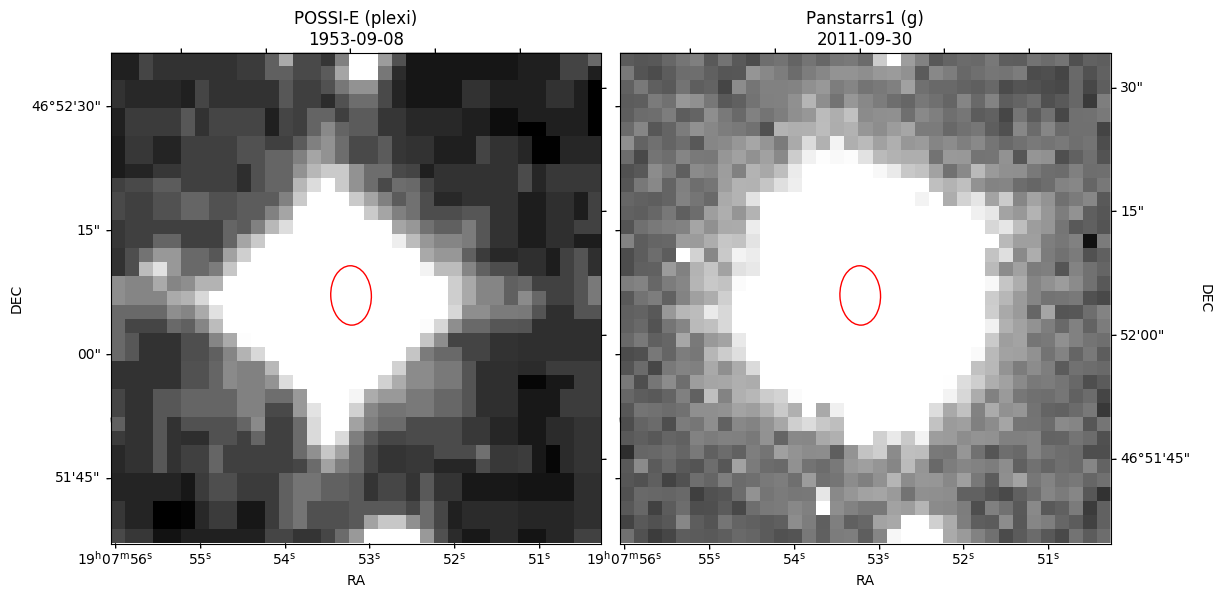

In [14]:
fig = plot_archival_images( tcoord.ra.deg,
                            tcoord.dec.deg,
                            survey1='dss1',
                            survey2='ps1',
                            fp1=None,
                            fp2=None,
                            height=1,
                            width=1,
                            cmap='gray',
                            reticle=True,
                        )